In [63]:
import numpy as np



##########-action constants-###################
N = 0
S = 1
E = 2
W = 3
NOOP = 4  


def discreteProb(p):
        # Draw a random number using probability table p (column vector)
        # Suppose probabilities p=[p(1) ... p(n)] for the values [1:n] are given, sum(p)=1 
        # and the components p(j) are nonnegative. 
        # To generate a random sample of size m from this distribution,
        #imagine that the interval (0,1) is divided into intervals with the lengths p(1),...,p(n). 
        # Generate a uniform number rand, if this number falls in the jth interval given the discrete distribution,
        # return the value j. Repeat m times.
        r = np.random.random()
        cumprob=np.hstack((np.zeros(1),p.cumsum()))
        sample = -1
        for j in range(p.size):
            if (r>cumprob[j]) & (r<=cumprob[j+1]):
                sample = j
                break
        return sample

def softmax(Q,x,tau):
    # Returns a soft-max probability distribution over actions
    # Inputs :
    # - Q : a Q-function represented as a nX times nU matrix
    # - x : the state for which we want the soft-max distribution
    # - tau : temperature parameter of the soft-max distribution
    # Output :
    # - p : probability of each action according to the soft-max distribution
    
    p = np.zeros((len(Q[x])))
    sump = 0
    for i in range(len(p)) :
        p[i] = np.exp((Q[x,i]/tau).round(5))
        sump += p[i]
    
    p = p/sump
    
    return p



def compare(V,Q,pol): 
    # compares the state value V with the state-action value Q following policy pol
    epsilon = 0.01 # precision of the comparison
    sumval = np.zeros((V.size))
    for i in range(V.size): # compute the difference between V and Q for each state
        sumval[i] = abs(V[i] - Q[i,pol[i]])
         
    if np.max(sumval)<epsilon :
        return True
    else :
        return False



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib.table import Table
from matplotlib import rc



###################-plot functions for a maze like environment-#################


##################################################

#### maze_mdp plot, used to plot the agent in its environment while processing the V/Q function and policy 
#### it can also create videos given a list of V/Q values and a list of policies

class maze_plotter():
    def __init__(self, maze, terminal_states): # maze defined in the mdp notebook
        self.maze_attr = maze
        self.terminal_states = terminal_states
        plt.ion()
        self.figW = self.maze_attr.width
        self.figH = self.maze_attr.height
        self.figure_history=[]
        self.axes_history=[]
        self.table_history=[]
        self.agent_patch_history = []
        
    def init_table(self): # the states of the mdp are drawn in a matplotlib table, this function creates this table
        
        width = 1 #0.1
        height = 1 #0.2
        
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width) :
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls :
                    color[0]=color[1]=color[2]=0
                else :
                    color[0]=color[1]=color[2]=1
                self.table_history[-1].add_cell(i,j, width, height, facecolor=color, text='', loc='center')
        
        self.axes_history[-1].add_table(self.table_history[-1])
    
    def new_render(self): # initializes the plot by creating its basic components (figure, axis, agent patch and table)
        # a trace of these components is stored so that the old outputs will last on the notebook 
        # when a new rendering is performed
        self.figure_history.append(plt.figure(figsize=(self.figW,self.figH)))
        self.axes_history.append(self.figure_history[-1].add_subplot(111)) # 111 : number of rows, columns and index of subplot
        self.table_history.append(Table(self.axes_history[-1], bbox=[0,0,1,1])) # [left, bottom, width, height]
        self.agent_patch_history.append(mpatches.Ellipse((-1,-1), 0.06, 0.085, ec="none", fc="dodgerblue", alpha=0.6))
        self.axes_history[-1].add_patch(self.agent_patch_history[-1])
        self.init_table()

    def coords(self, height, width, state): #processes the starting position of the arrows
        i = state%self.maze_attr.height
        j = int(state/self.maze_attr.height)
        h = 1/self.figH
        ch = h/2
        w = 1/self.figW
        cw = w/2
        x,y = j*w + cw,1-(i*h + ch)
        return x,y
    
    def render(self, agent_state=-1, V=[], policy=[], render=True): # updates the values of the table 
        # and the agent position and current policy 
        # some of these components may not show depending on the parameters given when calling this function
        if len(self.figure_history) == 0 : # new plot
            self.new_render()
        
       
        self.axes_history[-1].clear()
        self.axes_history[-1].add_table(self.table_history[-1])
        
        #### Table values and policy update
        if len(V)>0: # working with state values
            if len(V.shape)==1 :
                self.V_render(agent_state, V, policy, render) 
            else : # working with state values
                self.Q_render(agent_state, V, policy, render)

        
        if agent_state >= 0:
            x,y = self.coords(self.maze_attr.height, self.maze_attr.width, agent_state)
            
            
            self.agent_patch_history[-1].center = x,y
    
            self.axes_history[-1].add_patch(self.agent_patch_history[-1])
            #print(agent_state,i,x,j,y)
        
        #plt.subplots_adjust(left=0.2, bottom=0.2)
        plt.xticks([])
        plt.yticks([])
        if render :
            self.figure_history[-1].canvas.draw()
            self.figure_history[-1].canvas.flush_events()
        return self.figure_history[-1]
    
    
    def V_render(self, agent_state, V, policy, render):
        
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width):
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls:
                    color[0]=color[1]=color[2]=0
                else:
                    color[0]=color[1]=color[2]=np.min([1-V[state]/(np.max(V)+1),1])
                    
                self.table_history[-1]._cells[(i,j)].set_facecolor(color)

                self.table_history[-1]._cells[(i,j)]._text.set_text(np.round(V[state],2))
                
                if len(policy)>0 and not (state in self.maze_attr.walls or state in self.terminal_states):
                    x0, y0, x,y = self.arrow_params(self.maze_attr.height, self.maze_attr.width,
                                                        state, policy[state])
                    arw_color = "red"
                    alpha = 0.6
                        
                    if not(x == y and x == 0):
                        self.axes_history[-1].arrow(x0, y0, x, y, alpha=alpha,
                                      head_width=0.03, head_length=0.03, fc=arw_color, ec=arw_color)
        
        
    def Q_render(self, agent_state, Q, policy, render):
         
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width):
                
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls:
                    color[0]=color[1]=color[2]=0
                else:
                    color[0]=color[1]=color[2]=np.min([1-np.max(Q[state])/(np.max(Q)+1),1])
                    
                self.table_history[-1]._cells[(i,j)].set_facecolor(color)

                self.table_history[-1]._cells[(i,j)]._text.set_text(np.round(np.max(Q[state]),2))
                
                if not (state in self.maze_attr.walls or state in self.terminal_states):
                    qmin = np.min(Q[state])
                    if qmin < 0:
                        qmin *= -1
                    pos_Q = Q[state] + qmin
                    qmax = np.max(pos_Q)
                    norm_Q = pos_Q / (np.sum(pos_Q)-(list(pos_Q).count(qmax)*qmax)+0.1)
                    
                    
                    for action in range(len(Q[state])):
                        
                        x0, y0, x, y = self.qarrow_params(self.maze_attr.height, 
                                                    self.maze_attr.width, state, action)


                        arw_color = "green"
                        alpha = 0.9
                        qmax = np.max(Q[state])

                        if not Q[state][action]==qmax:
                            arw_color = "red"
                            alpha = norm_Q[action]

                        if x == 0 and y == 0:
                            circle = mpatches.Circle((x0, y0), 0.02, ec=arw_color, fc=arw_color, alpha=alpha)
                            self.axes_history[-1].add_patch(circle)
                        else:
                            self.axes_history[-1].arrow(x0, y0, x, y, alpha=alpha,
                                          head_width=0.03, head_length=0.02, fc=arw_color, ec=arw_color)



           
    def arrow_params(self, height, width, state, action): #processes the starting position of the arrows
        x,y= self.coords(height, width, state)
        
        if action == N :
            return [x, y+0.02, 0.0, 0.04]
        elif action == S :
            return [x, y-0.02, 0.0, -0.04]
        elif action == W :
            return [x-0.03, y, -0.02, 0.0]
        elif action == E :
            return [x+0.03, y, 0.02, 0.0]
        else :
            return [x, y, 0.0, 0.0]   
    
    def qarrow_params(self, height, width, state, action): #processes the starting position of the arrows
        x,y= self.coords(height, width, state)
        
        if action == N :
            return [x, y+0.03, 0.0, 0.0125] #1/(10*self.figH)]
        elif action == S :
            return [x, y-0.03, 0.0, -1/(10*self.figH)]
        elif action == W :
            return [x-0.03, y, -1/(10*self.figW), 0.0]
        elif action == E :
            return [x+0.03, y, 1/(10*self.figW), 0.0]
        else :
            return [x, y, 0.0, 0.0]   
        
        
    def save_fig(self, title):
        self.figure_history[-1].savefig(title)
        
    def update(self, frame, V_list, pol_list):
        if len(pol_list)>frame:
            return self.render(V=V_list[frame],policy=pol_list[frame], render=False)
        else:
            return self.render(V=V_list[frame], render=False)
    
    def create_animation(self, Q_list=[], pol_list=[], nframes=0):
        new_Qlist = Q_list
        new_polist = pol_list
        if nframes > 0 :
            new_Qlist, new_polist = self.resize_lists(Q_list, pol_list, nframes)
            
        self.new_render()
        anim = animation.FuncAnimation(self.figure_history[-1], self.update, frames=len(new_Qlist), 
                                       fargs=[new_Qlist, new_polist], blit=True)
        #plt.close()
        return anim
    
    def resize_lists(self, Q_list, policy_list, nb_frames): #gets samples from the data list to fit the number of frames 
        # to show in the animation
        # used when the length of the data list exceeds the number of the frames required for the video
                    
        if nb_frames < len(Q_list) :
            step = np.int(np.round(len(Q_list)/nb_frames,0))
            print("sample length : ",len(Q_list))
            print("nb of frames : ",nb_frames)
            print("step size : ",step)

            new_Qlist = []
            new_polist = []

            for i in range(0,len(Q_list),step) :
                new_Qlist.append(Q_list[i])
                if len(policy_list) > i:
                    new_polist.append(policy_list[i])            

            return new_Qlist, new_polist
        else :
            return Q_list, policy_list



In [64]:
import numpy as np

    
class simple_actspace(): #class describing the action space of the markov decision process
    def __init__(self, action_list=[], nactions=0):
        if len(action_list) == 0:
            self.actions = np.array([a for a in range(nactions)])
        else:
            self.actions = action_list
            
        self.size = len(self.actions)
        
    def sample(self, prob_list=None): #returns an action drawn according to the prob_list distribution, 
        # if the param is not set, then it is drawn from a uniform distribution 
        if prob_list is None :
            prob_list = np.ones((self.size))/self.size
            
        index = discreteProb(prob_list) 
        return  self.actions[index]
    

        
    
class mdp(): #defines a Markov Decision Process

    def __init__(self, observation_space, action_space, start_distribution, transition_matrix,
                  reward_matrix, plotter, gamma=0.9, terminal_states=[], timeout=50):
        
        self.observation_space = observation_space
        self.terminal_states = terminal_states
        self.action_space = action_space
        self.current_state = -1 #current position of the agent in the maze, it's set by the method reset()
        self.timeout = timeout #maximum length of an episode
        self.timestep = 0 
        self.P0 = start_distribution #distribution used to draw the first state of the agent, used in method reset()
        self.P = transition_matrix
        self.r = reward_matrix
        self.plotter = plotter #used to plot the maze
        self.gamma = gamma #discount factor
        self.last_action_achieved = False #used to tell whether the last state has been reached or not (see done())
    
    

    def reset(self, uniform=False): #initializes an episode and returns the state of the agent
        #if uniform is set to False, the first state is drawn according to the P0 distribution, 
        #else it's drawn on a uniform distribution over all the states
        
        if uniform :
            prob = np.ones((self.observation_space.size))/self.observation_space.size
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)
            
        self.timestep = 0
        self.last_action_achieved = False
        
        return self.current_state
 
    
    def step(self,u,deviation=0): # performs a step forward in the environment, 
        # if you want to add some noise to the reward, give a value to the deviation param 
        # which represents the mean μ of the normal distribution used to draw the noise 
        
        noise = 0 # = deviation*np.random.randn() # generate noise, see an exercize in mbrl.ipynb
        reward = self.r[self.current_state,u] +noise # r is the reward of the transition, you can add some noise to it 
        
        # the state reached when performing action u from state x is sampled 
        # according to the discrete distribution self.P[x,u,:]
        observation = discreteProb(self.P[self.current_state,u,:]) 
        
        self.timestep += 1 
        
        
        info = {} #can be used when debugging
        info["State transition probabilities"] = self.P[self.current_state,u,:]
        info["reward's noise value"] = noise
        
        self.current_state = observation
        done = self.done() #checks if the episode is over
        
        return [observation,reward,done,info]
    
    
    def done(self): #returns True if the episode is over
        if self.last_action_achieved :
            return True
        if self.current_state in self.terminal_states: #done when a terminal state is reached
            #the terminal states are actually a set of states from which any action leads to an added imaginary state, 
            #the "well", with a reward of 1. To know if the episode is over, we have to check
            #whether the agent is on one of these last states and performed the action that gives it its last reward 
            self.last_action_achieved = True
            
        return self.timestep == self.timeout #done when timeout reached
    
    
    def new_render(self): #initializes a new environment rendering (a plot defined by a figure, an axis...)
        self.plotter.new_render()
    
    def render(self, V=[], policy=[], agent_pos=-1): #outputs the agent in the environment with values V (or Q)
        
        if agent_pos > -1:
            self.plotter.render(agent_state=agent_pos, V=V, policy=policy)
        elif self.current_state > -1:# and not self.last_action_achieved:
            self.plotter.render(agent_state=self.current_state, V=V, policy=policy)
        else :
            self.plotter.render(V=V, policy=policy)
        
    def save_fig(self, title): #saves the current output into the disk
        self.plotter.save_fig(title)
            
    def create_animation(self,V_list=[],policy_list=[],nframes=0): #given a list of V or Q values, a list of policies, 
        # and eventually the number of frames wanted, it generates a video of the different steps
        return self.plotter.create_animation(V_list,policy_list,nframes)
    

class maze(): #describes a maze-like environment
    def __init__(self, width, height, walls=[]):
        self.width = width
        self.height = height
        self.states = np.array([s for s in range(width*height)])
        self.walls = walls
        self.size = width*height
     

    
class maze_mdp(mdp): #defines a Markov Decision Process which observation space is a maze

    def __init__(self, width, height, walls=[], action_list=[], nactions=4,
                 gamma=0.9, timeout=50, start_states=[0], terminal_states=[]):
        #width, height : int numbers defining the maze attributes
        #walls : list of the states that represent walls in our maze environment
        #action_list : list of possible actions
        #nactions : used when action_list is empty, by default there are 4 of them (go north, south, eat or west)
        #gamma : the discount factor of our mdp
        #timeout : defines the length of an episode (max timestep) --see done() function
        #start_states : list that defines the states where the agent can be at the beginning of an episode
        #terminal_states : list that defines the states corresponding to the end of an episode
        #                  (agent reaches a terminal state) --cf. done() function
        
        ###################### State Space ######################
        
        observation_space = maze(width, height, walls)
        
        ###################### Action Space ######################
        
        action_space = simple_actspace(action_list=action_list, nactions=nactions)    
        
        
        ###################### Distribution Over Initial States ######################
        
        start_distribution = np.zeros((observation_space.size)) #distribution over initial states
        
        for state in start_states:
            start_distribution[state] = 1.0/len(start_states)

        ###################### Transition Matrix ######################
        
        transition_matrix = np.empty((observation_space.size+1,action_space.size,observation_space.size+1)) #a "well" state is added that only the terminal states can get into
        
        # Transition Matrix when going north
        transition_matrix[:,N,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i == 0 or i%observation_space.height == 0 or i-1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (highest cells + cells under a wall)
                transition_matrix[:,N,:][i][i] = 1.0
            else : #it goes up
                transition_matrix[:,N,:][i][i-1] = 1.0
        
        # Transition Matrix when going south
        transition_matrix[:,S,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i%observation_space.height == observation_space.height-1 or i+1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (lowest cells + cells above a wall)
                transition_matrix[:,S,:][i][i] = 1.0
            else : #it goes down
                transition_matrix[:,S,:][i][i+1] = 1.0
    
        #self.P[:,S,:][49][50] = 0.2 #example for hacking local probabilities
        #self.P[:,S,:][49][48] = 0.8


        # Transition Matrix when going west
        transition_matrix[:,W,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i<observation_space.height or i-observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the right side of a wall)
                transition_matrix[:,W,:][i][i] = 1.0
            else : #it goes left
                transition_matrix[:,W,:][i][i-height] = 1.0
        

        # Transition Matrix when going east
        transition_matrix[:,E,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i>observation_space.size-observation_space.height-1 or i+observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the left side of a wall)
                transition_matrix[:,E,:][i][i] = 1.0
            else : #it goes right
                transition_matrix[:,E,:][i][i+height] = 1.0
                
        # Transition Matrix of final states 
        well = observation_space.size # all the final states' transitions go there
        for s in terminal_states:
            transition_matrix[s,:,:] = 0
            transition_matrix[s,:,well] = 1
            
        
        # Transition Matrix when not moving (action removed from the current version)
        #transition_matrix[:,NoOp,:] = np.eye(observation_space.size)

        ###################### Reward Matrix ######################

        reward_matrix = np.zeros((observation_space.size, action_space.size)) 
        for s in terminal_states:
            reward_matrix[s,:] = 1 # leaving a final state gets the agent a reward of 1
        #reward_matrix[-1][NoOp] = 1.0
        #reward_matrix[25][NoOp] = 0.9
        
        plotter = maze_plotter(observation_space, terminal_states) #renders the environment
        mdp.__init__(self, observation_space, action_space, start_distribution, transition_matrix,
                 reward_matrix, plotter, gamma=gamma, terminal_states=terminal_states, timeout=timeout)

    
    def reset(self, uniform=False): #initializes an episode
        #if uniform is set to False, the first state is drawn from the P0 distribution, 
        #else it is drawn from a uniform distribution over all the states except for walls
        if uniform:
            prob = np.ones((self.observation_space.size))/(self.observation_space.size-len(self.observation_space.walls))
            for state in self.observation_space.walls:
                prob[state]= 0.0 
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)

        self.timestep = 0
        self.last_action_achieved = False
        return self.current_state

In [109]:
import numpy as np

def PI_Q(mdp, render=True): # policy iteration over the Q function
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    pol = np.zeros(mdp.observation_space.size,dtype=np.int16)
    
    Q_list = [Q.copy()]
    policy_list = [pol.copy()]
    
    quitt = False
    
    if render:
        mdp.new_render()
    
    compteur_iteration = 0;
    while quitt==False:
        compteur_iteration += 1;
        if render:
            mdp.render(Q.max(axis=1),pol)
            
        # Step 1 : Policy Evaluation
        for x in mdp.observation_space.states:
            for u in mdp.action_space.actions:
                if x in mdp.terminal_states:
                    Q[x,u] = mdp.r[x,u]
                else :
                    sum = 0
                    for y in mdp.observation_space.states:
                        sum = sum + mdp.P[x,u,y]*Q[y,pol[y]]
                    Q[x,u] = mdp.r[x,u] + mdp.gamma*sum
        
            
        # Step 2 : Policy Improvement
        pol =  np.argmax(Q,axis=1)         
        
        # 
        Q_list.append(Q.copy())
        policy_list.append(pol.copy())
        
        # Check the convergence
        if np.array_equal(Q_list[-1],Q_list[-2]) :
            quitt = True
    
    if render:
            mdp.render(Q.max(axis=1),pol)
    print("Fini en {0} iteration",compteur_iteration);            
    return [Q_list,policy_list]

# Reinforcement learning functions

By contrast with dynamic programming functions, the reinforcement learning functions are applied when the MDP is unknown.
More precisely, the state and action spaces are known, but the agent does not know the transition nor the reward function.

In this notebook we focus on *model free* reinforcement learning, the model-based case is treated [here](mbrl.ipynb).

## TD learning

Given a state and an action spaces as well as a policy, TD(0) computes the state value of this policy based on the following equation: 
    $$V_{t+1}(x_t) = V_{t}(x_t) + \alpha\delta_t,$$
    
where $\delta_t = r(x_t,u_t) + \gamma V_{t}(x_{t+1})-V_{t}(x_t)$ is the TD error and $\alpha$ is a parameter called "learning rate".</span>


The code is provided below, so that you can take inspiration later on. The important part is the computation of $\delta$, and the update of the values of $V$.

Once you have understood the code, write in the cell just below the code to run it.

Hint: to run TD learning, you need a policy as input. You can retreive such a policy by using the policy iteration method defined in the [dynamic_programming.ipynb](dynamic_programming.ipynb) notebook. Just import it, call it, and use the resulting policy as evaluated policy.


In [78]:
import numpy as np

# Given state and action spaces and a policy, it computes the state value of this policy

def TD(mdp, pol, nEpisodes=100000, nTimesteps=25, render=True):
    V = np.zeros((mdp.observation_space.size)) #initial state value V
    V_list = [V.copy()]
    alpha = 0.15 #learning rate
    mdp.timeout = 25 #sets timeout of an episode (maximum number of timesteps) - default set to 50
    
    if render:
        mdp.new_render()
        
    print("***** Simulation en cours ***********")
    for i in range(nEpisodes) : #for each episode
        
        if i%100 == 0 :
          print(" Episode ",i);
          
        # Draw an initial state randomly (if uniform is set to False, the state is drawn according to the P0 
        #                                 distribution)
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done: #update episode at each timestep
            # Show agent
            if render:
                mdp.render(V, pol)
            
            # Step forward following the MDP: x=current state, 
            #                                 pol[i]=agent's action according to policy pol, 
            #                                 r=reward gained after taking action pol[i], 
            #                                 done=tells whether the episode ended, 
            #                                 and info gives some info about the process
            [y,r,done,info] = mdp.step(pol[x]) 
            
            # Update the state value of x
            if x in mdp.terminal_states:
                V[x] = r
            else:
                delta = r+mdp.gamma*V[y]-V[x]
                V[x] = V[x]+alpha*delta
            
            # Update agent's position (state)
            x=y
        
        # After each episode, we save the computed state value V
        V_list.append(V.copy()) 
    if render :
        mdp.render(V, pol)
    
    
    print("****** Fin de simulation *************");
    return V_list,V_list

In [116]:
"\\write here the code to call the above TD function"
%matplotlib notebook

startTime = time.time() 
walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)
[_, policy_list] = PI_Q(m,render=False)
[V_list, policy_list] = TD(m,policy_list[-1],nEpisodes=1000,render=False)
endTime = time.time();
print(nEpisodes,"episodes, time used:", endTime-startTime)

Fini en {0} iteration 11
***** Simulation en cours ***********
 Episode  0
 Episode  100
 Episode  200
 Episode  300
 Episode  400
 Episode  500
 Episode  600
 Episode  700
 Episode  800
 Episode  900
****** Fin de simulation *************
1000 episodes, time used: 0.44994544982910156


<IPython.core.display.Javascript object>


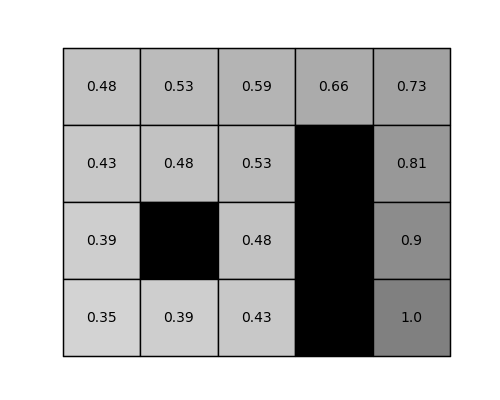

In [112]:
# visualize your final result
%matplotlib notebook

m.new_render()
m.render(V_list[-1], V_list[-1]) # V_list is the list of the V values of each episode, and same goes with polPI_list (policies)

## Q-learning

The QLearning algorithm accounts for an agent exploring an MDP and updating at each step a model of the state action-value function stored into a Q-table. It is updated as follows:
    $$Q_{t+1}(x_t,u_t) = Q_{t}(x_t,u_t) + \alpha \delta_t,$$
    
and the temporal difference error is processed using $\delta_t = r(x_t,u_t) + \gamma \max_{u_{t+1} \in A} Q_{(t)}(x_{t+1},u_{t+1})-Q_{t}(x_t,u_{t})$

The cell below gives the code of Q-learning, where you must just write the central update rule.


In [110]:
t = np.array([[1,2,3,4],[6,7,8,9],[10,11,12,13],[14,15,16,17],[1,1,1,1]]);
print(t.max(axis=1));
print(t.shape)
print(np.zeros((2,4)))

[ 4  9 13 17  1]
(5, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [72]:
import numpy as np

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning(mdp,tau,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = [Q.copy()]
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
    print(" ******* Simulation en cours ******************");   
    for i in range(nEpisodes) :
        
        if i%100 == 0 :
            print("Episode ", i);
        
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            u = mdp.action_space.sample(prob_list=softmax(Q,x,tau))

            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)
            
            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r;
            else:
                
                delta = r + mdp.gamma * Q_list[-1].max(axis=1)[y] - Q[x,u];
                Q[x,u] = Q[x,u] + alpha * delta;
            
            # Update agent's position
            x = y
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    
    print("******* Fin de simulation*****************")
    return [Q_list, policy_list]

Now, write the code to run Q-learning below

In [107]:
"run the Q-learning code here"
%matplotlib notebook
import time

startTime = time.time() 
walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)
alpha = 0.9
print("alpha =", alpha)
nEpisodes = 1000
[Q_list, policy_list] = QLearning(m,1,nEpisodes = nEpisodes,render=False,alpha = alpha)
endTime = time.time();
print(nEpisodes,"episodes, time used:", endTime-startTime)

alpha = 0.9
 ******* Simulation en cours ******************
Episode  0
Episode  100
Episode  200
Episode  300
Episode  400
Episode  500
Episode  600
Episode  700
Episode  800
Episode  900
******* Fin de simulation*****************
1000 episodes, time used: 7.2567524909973145


<IPython.core.display.Javascript object>


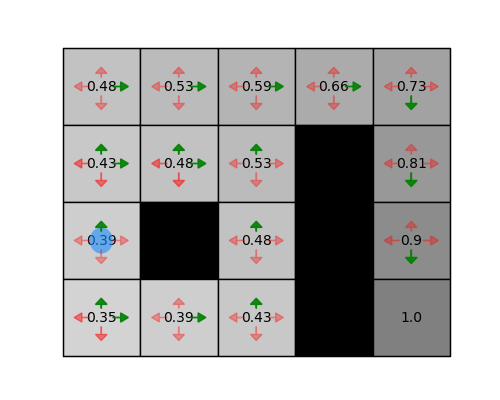

1000 episodes, time used: 216.62934112548828


In [105]:
# Visualize your results

# In DP, the rendering was done in real time, meaning that as the Q values were being processed, the maze environment
# was updated, even for rather large mazes. For RL algorithms, convergence is slower, 
# so we suggest you to build a much smaller maze, using for instance:
# walls = [6, 13, 14, 15]
# height = 4
# width = 5
# terminal_states=[width*height-1]
# m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

# As output, lists of the Q values and policies are stored and can be used either to show the result offline
# or to generate videos that you can show on the notebook or save into your disk

%matplotlib notebook

from IPython.display import HTML  # used to display the video on the notebook

m.new_render()
m.render(Q_list[-1], policy_list[-1])  # QPI_list is the list of the Q values processed at each episode, 

# polPi_list is the list of the policies

# you can generate a video of your learning process using those lists
# nb_frames = 100 # number of frames of your video
# ani = m.create_animation(QPI_list, polPI_list, nb_frames) # generate your video
# HTML(ani.to_jshtml()) # show your video on the notebook (with a video widget than enables you to manage your output)
# ani.save("Q_learning.mp4") # save your video

 ### Learning dynamics
    
If you watch carefully the values while the agent is learning, you will see that the agent favors certains paths over others which have a strictly equivalent value. This can be explained easily: as the agent chooses a path for the first time, it updates the values along that path, these values get higher than the surrounding values, and the agent will choose the same path again and again, increasing the phenomenon. Only steps of random exploration can counterbalance this effect, but they do so extremely slowly.

### Effect of hyper-parameters

There are three hyper-parameters in Q-learning: the softmax temperature $\tau$, the learning rate $\alpha$, and the discount factor $\gamma$. Using a small maze, try various values for these hyper-parameters and explain what is happenning.



### Exploration


In the code above, action selection is based on a soft-max policy. Instead, it could have relied on *epsilon-greedy*.
Copy-paste the above code below and do the replacement.

In [95]:
"copy-paste and replace here"
import numpy as np

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning_epsilon(mdp,pas=0.001,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    # epsilon
    epsilon = 0;
    
    
    Q_list = [Q.copy()]
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
        
    print("*****Simulation en cours***********************************");
    for i in range(nEpisodes) :
        
        if i % 100 == 0:
            print("Episodes ",i);
            
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using epsilon-greedy
            if (np.random.random() > epsilon):
                u = np.random.choice(mdp.action_space.actions);
                mode_exploration = True;
                #exploitation = False;
            else:
                u = Q_list[-1].argmax(axis=1)[x];
                mode_exploration = False;
                #exploitation = True;
            
            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)
            
            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r;
            else:
                delta = r + mdp.gamma * Q_list[-1].max(axis=1)[y] - Q[x,u];
                Q[x,u] = Q[x,u] + alpha * delta;
            
            #updata epsilon
            if mode_exploration:
                if Q[x,u]>Q_list[-1][x,u]:
                    epsilon += pas;
                else:
                    epsilon -= pas;
            
            # Update agent's position
            x = y
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
    print("*****Fin de simulation***************************")
    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

alpha = 0.9
*****Simulation en cours***********************************
Episodes  0
Episodes  100
Episodes  200
Episodes  300
Episodes  400
Episodes  500
Episodes  600
Episodes  700
Episodes  800
Episodes  900
*****Fin de simulation***************************
1000 episodes, time used: 3.880972146987915


<IPython.core.display.Javascript object>


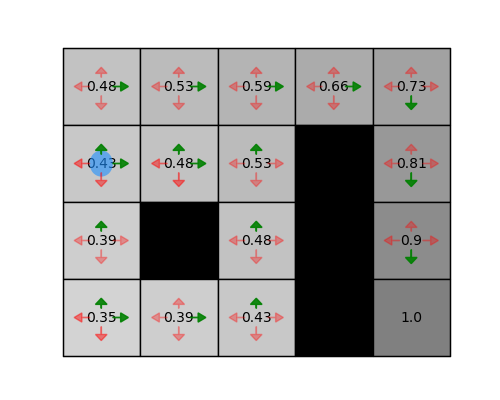

In [133]:
"run the Q-learning code here"
%matplotlib notebook

startTime = time.time() 
walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)
alpha = 0.9
print("alpha =", alpha)
[Q_epsilon_list, policy_epsilon_list] = QLearning_epsilon(m,nEpisodes = 1000,render=False,alpha = alpha)
#from IPython.display import HTML  # used to display the video on the notebook
endTime = time.time();
print(nEpisodes,"episodes, time used:", endTime-startTime)
m.new_render()
m.render(Q_epsilon_list[-1], policy_epsilon_list[-1])

## SARSA

The SARSA algorithm is very similar to Q_learning. At first glance, the only difference is in the update rule. However, to perform the update in SARSA, one needs to know the action the agent will take when it will be at the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored for being played at the next time step.


By taking inspiration from the above Qlearning function, write in the cell below a Sarsa function that implements the corresponding algorithm. Then write the code to run it in the cell after.

In [142]:
"copy-paste and replace here"
import numpy as np

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def SARSA(mdp,pas=0.001,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    # epsilon
    epsilon = 0;
    
    
    Q_list = [Q.copy()]
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
        
    print("*****Simulation en cours***********************************");
    for i in range(nEpisodes) :
        
        if i % 100 == 0:
            print("Episodes ",i);
            
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        if (np.random.random() > epsilon):
            u = np.random.choice(mdp.action_space.actions);
            mode_exploration = True;
            #exploitation = False;
        else:
            u = Q_list[-1].argmax(axis=1)[x];
            mode_exploration = False;
            #exploitation = True;
            
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)
            
            # Draw an action using epsilon-greedy
            if (np.random.random() > epsilon):
                u1 = np.random.choice(mdp.action_space.actions);
                mode_exploration = True;
                #exploitation = False;
            else:
                u1 = Q_list[-1].argmax(axis=1)[y];
                mode_exploration = False;
                #exploitation = True;
            
            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r;
            else:
                delta = r + mdp.gamma * Q_list[-1][y][u1] - Q[x,u];
                Q[x,u] = Q[x,u] + alpha * delta;
            
            #updata epsilon
            if mode_exploration:
                if Q[x,u]>Q_list[-1][x,u]:
                    if epsilon < 1-pas:
                        epsilon += pas;
                else:
                    if epsilon >= pas:
                        epsilon -= pas;
            
            # Update agent's position
            x = y
            u = u1
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
    print("*****Fin de simulation***************************")
    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

alpha = 0.9
*****Simulation en cours***********************************
Episodes  0
Episodes  100
Episodes  200
Episodes  300
Episodes  400
Episodes  500
Episodes  600
Episodes  700
Episodes  800
Episodes  900
Episodes  1000
Episodes  1100
Episodes  1200
Episodes  1300
Episodes  1400
Episodes  1500
Episodes  1600
Episodes  1700
Episodes  1800
Episodes  1900
*****Fin de simulation***************************
2000 episodes, time used: 7.017687559127808


<IPython.core.display.Javascript object>


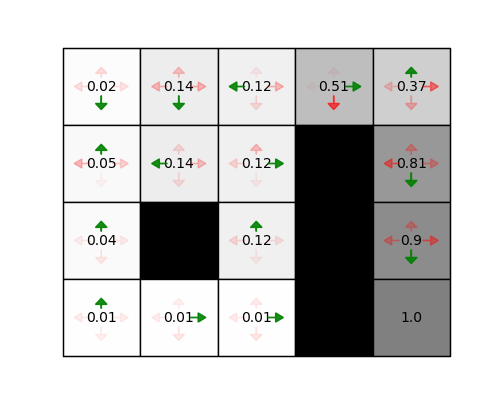

In [143]:
"run SARSA here"
%matplotlib notebook

startTime = time.time() 
walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)
alpha = 0.9
print("alpha =", alpha)
nEpisodes = 2000
[Q_list, policy_list] = SARSA(m,nEpisodes = nEpisodes,render=False,alpha = alpha)
#from IPython.display import HTML  # used to display the video on the notebook
endTime = time.time();
print(nEpisodes,"episodes, time used:", endTime-startTime)
m.new_render()
m.render(Q_list[-1], policy_list[-1])

## Wrapping up

Compare the number of steps needed by Qlearning and Sarsa to converge on the given MDP. To figure out, add a counter of number of steps to your various algorithms, and run them for a given number of steps (for instance, 10.000). Then watch the corresponding Q-table: can you determine if one was updated more than another? Eventually, do so with much smaller mazes...